In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [3]:
class GoT_User(User):
    
    def __init__(self, locs, svr_locs, mu, idx, 
                 max_dist = 7, threshold_dist = 6, self_weight = 0.5, P = None,
                 c1 = 100, c2 = 600, c3 = 600, delta = 0, rho = 0.5, epsilon = 0.01,
                 c = None, horizon = 15000):
        """
        ceiling = max number of reservation time step
        sticky_mode = stick with same arm for set number of time steps once reserved
        kick_mode = other user with higher production can interupt reservation when collision
        """
        # max dist - reward range
        # threshold dist - used for generating markov chain
        
        self.idx = idx
        self.locs = locs
        self.dists = self.get_dists()
        self.svr_locs = svr_locs
        self.mu = mu # True weights
        
        self.t = 0 # Time-steps past
        self.mode = "blind" # oracle
        self.phase = 0 #{0-exploration,1-GoT,2-exploitation}
        self.t_p = 0 #{timestep within phase }
        self.k = 0 # epoch
        
        self.c1 = c1
        self.c2 = c2
        self.c3= c3
        self.horizon = horizon
        
        self.delta = delta
        self.rho = rho
        self.epsilon = epsilon
        if c == None:
            self.c = len(svr_locs)
        else:
            self.c = c
        self.got_base_arm = 0
        
        
        if P is None:
            self.P = self.make_P(threshold_dist, self_weight)
        else:
            self.P = P
            
        self.reward_dists = self.get_reward_dists()
        self.reward_scale = self.get_scales(max_dist)
        self.usr_place = self.init_loc()
        
        self.stationary_loc = self.get_stationary_loc()
        self.stationary_reward_scale = self.get_stationary_scale()
        
        # Initialize learning parameters
        self.pulls = np.zeros(len(svr_locs))
        self.param_summed = np.zeros(len(svr_locs))
        self.Ftni = np.zeros(len(svr_locs)) # number of rounds in content state
        self.Fmax_idx = 0 # arm to pull during exploitation phase
        self.mu_est = np.zeros(len(svr_locs))
        self.state = 'discontent'
        
        self.epoch_time_mapping = np.zeros(horizon)
        self.phase_time_mapping = np.zeros(horizon)
        
        self.set_epochs()
        
        self.ucb_present = self.mu_est
        self.expected_time = 1
        self.ceiling = 1

        # history
        self.history_location = []
        self.history_pull = []
        self.history_reward = []
        self.history_collisions = []
        
    def set_epochs(self):
        
        pass_flag = True
        curr_phase = 0
        t_track = 0
        temp_k = 1
        
        while pass_flag:
            if curr_phase == 0:
                num_steps = self.c1
            elif curr_phase == 1:
                num_steps = self.c2 * (temp_k)**(1+self.delta)
            elif curr_phase == 2:
                num_steps = self.c3 * 2**(temp_k)
            
            end_time = t_track + num_steps
            
            if end_time >= self.horizon:
                end_time = self.horizon
                pass_flag = False
            
            self.epoch_time_mapping[t_track:end_time] = (temp_k) 
            self.phase_time_mapping[t_track:end_time] = curr_phase
            
            curr_phase += 1
            t_track = end_time
            
            if curr_phase > 2:
                curr_phase = 0
                temp_k += 1
            
        return
            
        
    def update_mean(self):
        """
        Update decision variables for next round
        """

        reward_record = self.param_summed
        pulls_record = self.pulls
        
        for s in range(reward_record.shape[0]):
            if pulls_record[s] > 0:
                mean = reward_record[s]/pulls_record[s]
                self.mu_est[s] = mean
    
    
    def choose_arm(self):
        # Choose an arm to pull based on collision restriction and UCB info
        
        phase = self.phase_time_mapping[self.t]
        
        if phase == 0: # Exploration Phase
            arm_id = np.random.randint(low=0, high=len(self.svr_locs))
        elif phase == 1: # GoT Phase
            if self.state == 'content':
                sub_arm_prob = self.epsilon**self.c / (len(self.svr_locs)-1)
                pdf = np.ones(len(self.svr_locs)) * sub_arm_prob
                pdf[self.got_base_arm] = 1 - self.epsilon**self.c
                arm_id = np.random.choice(len(self.svr_locs), 1, p=pdf)[0]
            elif self.state == 'discontent':
                arm_id = np.random.randint(low=0, high=len(self.svr_locs))
        elif phase == 2: # Exploitation Phase
            arm_id = self.Fmax_idx
        
        return arm_id
    
    def receive_reward(self, arm_id, reward, collision_flag, max_reward, wait_time, chosen_idx,
                       reservation_mode = False):

        phase = self.phase_time_mapping[self.t]
#         scale = self.stationary_reward_scale[arm_id]
        scale = self.reward_scale[self.usr_place][arm_id]
        constant = 0.001
        
        if phase == 0: # Exploration Phase                              
            if not collision_flag:
                self.pulls[arm_id] += 1
                self.param_summed[arm_id] += reward[self.idx]/(scale+constant)
                self.update_mean()
        elif phase == 1: # GoT Phase
            if arm_id == self.got_base_arm and not collision_flag and self.state == 'content':
                if self.t_p > np.ceil(self.rho*self.c2*self.k**(1+self.delta)):
                    self.Ftni[self.got_base_arm] += 1
            else:
                self.got_base_arm = arm_id
                uns = self.stationary_reward_scale* self.mu_est
                un_max = np.max(uns)
                un = uns[arm_id] * (1-collision_flag)
                prob_c = (un/un_max)*self.epsilon**(un_max-un)
                if np.random.binomial(n=1,p=prob_c) == 1:
                    self.state = 'content'
                    if self.t_p > np.ceil(self.rho*self.c2*self.k**(1+self.delta)):
                        self.Ftni[self.got_base_arm] += 1
                else:
                    self.state = 'discontent'
        elif phase == 2: # Exploitation Phase
            pass
        
            
        # Update history
        self.history_location += [self.usr_place]
        self.history_pull += [arm_id]
        self.history_reward += [reward]
        self.history_collisions += [collision_flag]
        
        self.advance_time()
        
    def advance_time(self):
        self.t += 1
        self.t_p += 1
        
        try:
            prev_epoch = self.epoch_time_mapping[t-1]
            now_epoch = self.epoch_time_mapping[t]
            prev_phase = self.phase_time_mapping[t-1]
            now_phase = self.phase_time_mapping[t]
            
            if prev_epoch != now_epoch: # Reset all epoch (2-->0)
                self.t_p = 0
                self.state = 'discontent'
                self.Ftni = np.zeros(len(svr_locs)) # number of rounds in content state
                self.Fmax_idx = 0
                
            elif prev_phase != now_phase: # Go to next phase
                self.t_p = 0
                
                if now_phase == 2:
                    self.Fmax_idx = np.argmax(self.Ftni) 
        except:
            pass
#             print("advance time pass")

In [4]:
# System Parameters
T = 20000
num_users = 6
num_svrs = 9
num_locs = 9
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 40
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big

num_explore = 1
trials = 3

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)
# svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)
svr_locs = gen_rand_locs(space_1d=space_1d_dim, nums=num_svrs)


with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)


# Create Users
Users = []
for i in range(num_users):
    P_temp = P_collection
    Users += [User(usr_locs,svr_locs,mu[i],i,
                  max_dist = 5, threshold_dist = 6, self_weight = 1 - 0.85, P = P_temp, ceiling = ceiling,
                  sticky_mode = True, kick_mode=True)]

GoT_Users = []
for i in range(num_users):
    GoT_Users += [GoT_User(usr_locs, svr_locs, mu[i], i, 
                 max_dist = 5, threshold_dist = 6, self_weight = 1 - 0.95, P = Users[i].P,
                 c1 = 5000, c2 = 6000, c3 = 6000, delta = 0, rho = 0.5, epsilon = 0.001,
                 c = num_users, horizon = T)]
    
# Create Servers
Servers = []
for i in range(num_svrs):
    Servers += [Server(svr_locs[i],mu,i)]

# Recorded Values - reservation
regret_g = np.zeros(T)
collision_count_g = np.zeros(T)
optimal_reward_g = np.zeros(T)
regret_g_compstat = np.zeros(T)

regret = np.zeros(T)
collision_count = np.zeros(T)
optimal_reward = np.zeros(T)


explore_rounds(Users, num_users, Servers, mu, regret, collision_count, optimal_reward,
                   usr_move_flag = True, rounds=num_explore)

round_start = ((num_svrs)*num_explore)+1

for t in range(round_start):
    w = obtain_w(GoT_Users, len(Users), len(Servers))
    optimal = offline_optimal_action(w, mu)
    play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
               usr_move_flag = True, debugger=False, reservation_mode = False, optimal=optimal, t = t)
    
copy_usr_loc(Users, GoT_Users)

# Centralized - stationary w, known mu
w_stat = obtain_w_stationary(Users, num_users, num_svrs)
optimal_stat_arms = offline_optimal_action(w_stat,mu)[0]
regret_cst = copy.deepcopy(regret)

for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
    w = obtain_w(Users, len(Users), len(Servers))
    optimal = offline_optimal_action(w, mu)
    optimal_reward[t] = optimal[1]
    play_round(Users, Servers, mu, regret, collision_count, 
               usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal, t = t)
    play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
               usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal, t = t)
    copy_usr_loc(Users, GoT_Users)
    
    # centralized solution - stationary w, known mu
    regret_cst[t] = optimal[1] - expected_reward(optimal_stat_arms, mu, w) 
    regret_g_compstat[t] = regret_g[t] - regret_cst[t]

<ipython-input-4-4b200a08c188>:88: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):


In [5]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [6]:
GoT_Users[0].stationary_reward_scale[1]

0.18801565228149597

In [7]:
GoT_Users[0].epoch_time_mapping[1899]

1.0

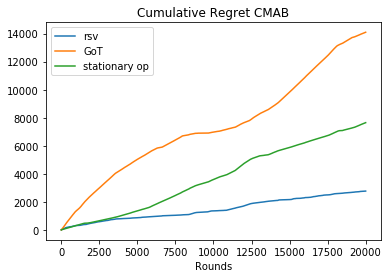

In [8]:
plot_idx = 1

plt.plot(np.cumsum(regret), label = 'rsv')
plt.plot(np.cumsum(regret_g), label = 'GoT')
plt.plot(np.cumsum(regret_cst), label = 'stationary op')
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.legend()

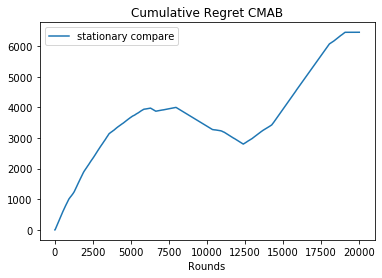

In [9]:
plot_idx = 1

plt.plot(np.cumsum(regret_g_compstat), label = 'stationary compare')
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.legend()

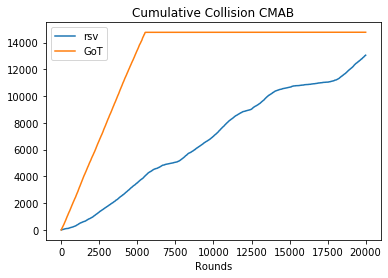

In [10]:
plot_idx = 1

plt.plot(np.cumsum(collision_count), label = 'rsv')
plt.plot(np.cumsum(collision_count_g), label = 'GoT')
plt.title('Cumulative Collision CMAB')
plt.xlabel('Rounds')
plt.legend()

In [11]:
for i in range(num_users):
    print(GoT_Users[i].mu_est)

[0.00927547 0.24288647 0.14123333 0.0172976  0.41269624 0.1890182
 0.3177857  0.24586739 0.14292811]
[0.03460217 0.01359921 0.88098095 0.02361288 0.02067978 0.77750505
 0.76893458 0.92346084 0.76216279]
[0.00291101 0.00322672 0.00775    0.02395949 0.14123049 0.
 0.01727459 0.         0.        ]
[0.01261138 0.09173413 0.57702237 0.01332389 0.17366389 0.27809981
 0.38895813 0.06101468 0.65898061]
[0.01342145 0.16660516 0.10149544 0.00619838 0.02103229 0.6376121
 0.15530147 0.40303916 0.5120948 ]
[0.01309956 0.06082366 0.00022251 0.01163541 0.11343998 0.08891211
 0.00314185 0.00914083 0.01934545]


In [12]:
for i in range(num_users):
    print(mu[i])

[0.6868604  0.65343721 0.42645382 0.80767297 0.89682072 0.57520188
 0.7601692  0.68707998 0.34008246]
[0.92927002 0.03456753 0.88190146 0.93937603 0.54725329 0.77542541
 0.78617719 0.92676498 0.73755319]
[0.1659878  0.38741964 0.75532704 0.86971107 0.19052271 0.85342094
 0.37993234 0.24180586 0.00462658]
[0.41869813 0.13741773 0.90863084 0.31632262 0.73608641 0.44413548
 0.64801614 0.08448012 0.97064977]
[0.55617694 0.149789   0.13012261 0.24643488 0.35911467 0.67160465
 0.19305398 0.67456636 0.69237515]
[0.75424456 0.6268575  0.11762225 0.91402866 0.19214446 0.81584031
 0.04735283 0.83437982 0.68264221]


In [13]:
for i in range(num_users):
    print(GoT_Users[i].mu_est * GoT_Users[i].stationary_reward_scale)

[4.81562357e-05 4.56664577e-02 2.71427081e-02 2.93670876e-05
 3.48889810e-03 3.66071989e-02 5.68450116e-02 6.51748181e-03
 2.58610526e-02]
[1.79647095e-04 2.55686392e-03 1.69309953e-01 4.00888806e-05
 1.74825093e-04 1.50579585e-01 1.37545819e-01 2.44792085e-02
 1.37903821e-01]
[1.51133605e-05 6.06674515e-04 1.48942155e-03 4.06773453e-05
 1.19395031e-03 0.00000000e+00 3.09005185e-03 0.00000000e+00
 0.00000000e+00]
[6.54755643e-05 1.72474518e-02 1.10894146e-01 2.26206957e-05
 1.46813940e-03 5.38596552e-02 6.95762240e-02 1.61738423e-03
 1.19234296e-01]
[6.96812975e-05 3.13243780e-02 1.95057431e-02 1.05233312e-05
 1.77805124e-04 1.23486484e-01 2.77800856e-02 1.06838094e-02
 9.26571469e-02]
[6.80101223e-05 1.14357994e-02 4.27624762e-05 1.97540776e-05
 9.59011704e-04 1.72196288e-02 5.62009430e-04 2.42306098e-04
 3.50031711e-03]


In [14]:
for i in range(num_users):
    print(mu[i] * GoT_Users[i].stationary_reward_scale)

[0.00356603 0.12285642 0.08195736 0.00137123 0.00758164 0.11139948
 0.13597788 0.0182132  0.06153367]
[0.00482457 0.00649924 0.16948686 0.00159483 0.00462643 0.15017682
 0.14063015 0.02456679 0.13345102]
[0.00086177 0.07284096 0.14516135 0.00147656 0.00161066 0.16528223
 0.06796171 0.00640982 0.00083712]
[0.00217379 0.02583669 0.1746238  0.00053704 0.00622281 0.08601582
 0.11591612 0.00223941 0.17562693]
[0.00288755 0.02816268 0.02500741 0.00041839 0.00303592 0.13006983
 0.03453319 0.01788148 0.12527662]
[0.00391588 0.11785902 0.02260505 0.0015518  0.00162437 0.15800398
 0.0084704  0.02211784 0.12351557]


In [15]:
got_arms = []
for i in range(len(GoT_Users)):
    got_arms += [GoT_Users[i].Fmax_idx]

In [16]:
optimal[0]

[5, -1, -1, 4, -1, 8]

In [17]:
optimal_stat_arms

[6, 2, 5, 8, 7, 1]

In [18]:
got_arms

[6, 7, 2, 8, 5, 1]

In [19]:
arm_id = np.random.randint(low=0, high=16)

In [20]:
arm_id

4

In [21]:
for i in range(len(GoT_Users)):
    print(GoT_Users[i].Ftni)

[   0.   54.   20.    0.    9.   12. 5555.    6.   10.]
[   0.    0.   47.    0.    0.   53.   44. 5492.   54.]
[3.00e+00 3.10e+01 5.53e+03 0.00e+00 3.00e+01 0.00e+00 3.20e+01 0.00e+00
 0.00e+00]
[3.000e+00 2.000e+00 4.800e+01 0.000e+00 0.000e+00 1.600e+01 1.500e+01
 0.000e+00 5.541e+03]
[0.000e+00 1.000e+00 7.000e+00 0.000e+00 0.000e+00 5.525e+03 6.000e+00
 4.000e+00 7.000e+01]
[0.000e+00 5.531e+03 0.000e+00 0.000e+00 5.000e+00 6.400e+01 0.000e+00
 0.000e+00 4.000e+00]


In [22]:
GoT_Users[i].stationary_reward_scale

array([0.00519179, 0.18801565, 0.19218344, 0.00169776, 0.00845391,
       0.19367023, 0.17887844, 0.02650812, 0.18093749])

In [23]:
svr_locs

[(8.906128272029012, 8.551018503849974),
 (4.821173865461428, 0.6108840329230669),
 (7.195933802245392, 3.858951788970396),
 (9.80838957784836, 9.190019760322702),
 (6.646654959616997, 9.00335992928038),
 (4.350777385562213, 1.0022083543776794),
 (6.931974322833936, 3.9215962246406786),
 (8.966620023898862, 6.42569095906442),
 (6.977330484009333, 3.9161858633238755)]

In [24]:
Users[1].P

array([[9.87643694e-01, 1.19398012e-02, 5.55339590e-05, 3.05436775e-04,
        2.77669795e-05, 0.00000000e+00, 2.77669795e-05, 0.00000000e+00,
        0.00000000e+00],
       [7.39914163e-01, 2.54935622e-01, 0.00000000e+00, 8.58369099e-04,
        4.29184549e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.19032032e-05, 0.00000000e+00, 9.95214912e-01, 0.00000000e+00,
        0.00000000e+00, 4.70176525e-03, 5.95160158e-05, 0.00000000e+00,
        1.19032032e-05],
       [7.19424460e-02, 1.07913669e-02, 0.00000000e+00, 7.37410072e-01,
        1.40287770e-01, 0.00000000e+00, 3.95683453e-02, 0.00000000e+00,
        0.00000000e+00],
       [8.75656742e-04, 4.37828371e-03, 8.75656742e-04, 3.67775832e-02,
        8.90542907e-01, 3.59019264e-02, 1.75131348e-03, 2.88966725e-02,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.90984004e-01, 0.00000000e+00,
        2.08434319e-02, 7.87687833e-01, 0.00000000e+00, 0.00000000e+00,
        4.8